In [3]:
%pip install pyradiomics dicom_numpy pydicom plotly matplotlib scikit-image simpleITK pynrrd dicom2nifti NiBabel NiLearn openpyxl pydicom-seg itkwidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from matplotlib import patches, text, patheffects

import dicom_numpy
import pydicom as dicom

import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import SimpleITK as sitk
import os

from radiomics import featureextractor

from tqdm import tqdm
import itertools
from functools import wraps

c:\ProgramData\Anaconda3\envs\mri_project\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [5]:
annotation_boxes = pd.read_excel("../../Simple Path Dataset/Annotation_Boxes.xlsx").set_index("Patient ID")

DATASET_PATH = '../../New Dataset/'
# SEGMENTED_DATASET_PATH = '../../Segmented Dataset/'

In [6]:
annotation_boxes

,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
Patient ID,,,,,,
Breast_MRI_001,234,271,308,341,89,112
Breast_MRI_002,251,294,108,136,59,72
Breast_MRI_003,351,412,82,139,96,108
Breast_MRI_004,262,280,193,204,86,95
Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...
Breast_MRI_918,345,395,338,395,62,85
Breast_MRI_919,285,312,369,397,98,109
Breast_MRI_920,172,193,337,355,87,101


In [7]:
annotation_boxes.loc['Breast_MRI_001']

Start Row       234
End Row         271
Start Column    308
End Column      341
Start Slice      89
End Slice       112
Name: Breast_MRI_001, dtype: int64

In [8]:
# filenames = ['pre.nii.gz', 'post_1.nii.gz']

In [9]:
def relu(x):
    return np.maximum(x, 0)

Start Row       351
End Row         412
Start Column     82
End Column      139
Start Slice      96
End Slice       108
Name: Breast_MRI_003, dtype: int64


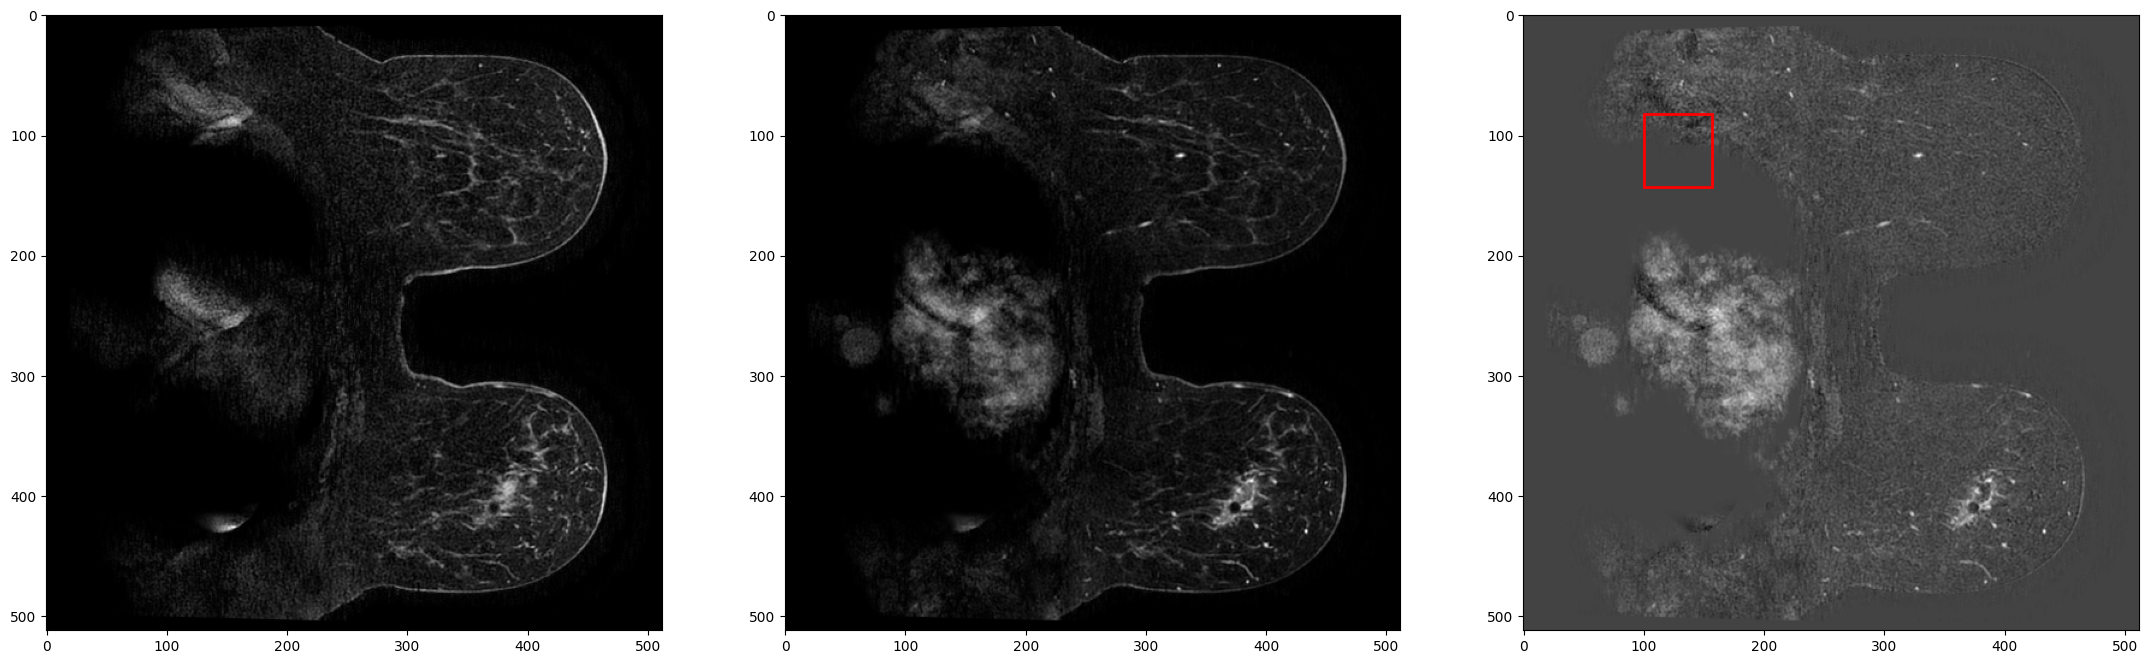

In [20]:
item = os.listdir(DATASET_PATH)[2]
# for item in tqdm(os.listdir(DATASET_PATH)):
patient_path = os.path.join(DATASET_PATH, item)

precontrast = nib.load(patient_path + '/pre.nii.gz')
postcontrast = nib.load(patient_path + '/post_1.nii.gz')

x = annotation_boxes.loc[item]
row1 = x['Start Row']
row2 = x['End Row']

col1 = x['Start Column']
col2 = x['End Column']

slice1 = x['Start Slice']
slice2 = x['End Slice']


height, width, depth = precontrast.shape
row1, row2, col1, col2 = col1, col2, width - row2, width - row1         # row => column, column => width - row, slice => depth - slice
slice1 = depth - slice1
slice2 = depth - slice2

print(x)


precontrast_data = relu(precontrast.get_fdata())
postcontrast_data = relu(postcontrast.get_fdata())
diff_contrast = postcontrast_data - precontrast_data

fig, ax = plt.subplots(1, 3, figsize = (27, 9))

s = (slice1 + slice2)//2                                     # num slices - current slice

ax[0].imshow(precontrast_data[:, :, s], cmap = 'gray')
ax[1].imshow(postcontrast_data[:, :, s], cmap = 'gray')
ax[2].imshow(diff_contrast[:, :, s], cmap = 'gray')

ax[2].add_patch(patches.Rectangle((col1, row1), row2-row1, col2-col1, fill = False, edgecolor = 'red', lw = 2))

In [12]:
sitk.Show(post_1_img)

In [13]:
sitk.Show(difference_arr)